# LONG SHORT TERM MEMORY (LSTM)

In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

EUR_VND

In [45]:
eur = pd.read_csv('EUR_VND.csv')

# Convert
eur = eur['Sale'].replace({',':''}, regex=True).astype(float)
# Scale data
# Scaler model
scaler = MinMaxScaler(feature_range=(0, 1))
# EUR - VND
eur_sc = scaler.fit_transform(np.array(eur).reshape(-1, 1))

In [46]:
# Function to standardize the data
def standardize_data(train, test, pre_test, f3, f6, f9):
    # Train
    train = np.reshape(train, (-1,1))
    train1 = scaler.inverse_transform(train)
    # Test
    test = np.reshape(test, (-1,1))
    test1 = scaler.inverse_transform(test)
    # Test prediction
    pre_test = np.reshape(pre_test, (-1,1))
    pre_test1 = scaler.inverse_transform(pre_test)
    # Forecast 30
    f3 = np.reshape(f3, (-1,1))
    f3_tf= scaler.inverse_transform(f3)
    # Forecast 60
    f6 = np.reshape(f6, (-1,1))
    f6_tf= scaler.inverse_transform(f6)
    # Forecast 90
    f9 = np.reshape(f9, (-1,1))
    f9_tf= scaler.inverse_transform(f9)
    
    return train1, test1, pre_test1, f3_tf, f6_tf, f9_tf 

# Convert train, test data into X_train, y_train, X_test, y_test

# Function to convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   # i=0, X=0,1,2,3-----99   Y=100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Function to convert data
def convert_data(train, test, time_step):
    # Reshape into X = t, t+1, t+2 ,..., t+99 and Y = t+100
    X_train, y_train = create_dataset(train, time_step)
    X_test, y_test = create_dataset(test, time_step)
    # Reshape input to be [samples, time steps, features] which is required for LSTM
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , 1)  # => 3D
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , 1)
    return X_train, y_train, X_test, y_test

# Function to forecast next 30, 60, 90 days data
def forecast_days(model, test):
    x_input = test[len(test)-100:].reshape(1,-1)

    temp_input = list(x_input)
    temp_input = temp_input[0].tolist()

    forecast30 = []
    forecast60 = []
    forecast90 = []
    n_steps = 100
    i = 0
    while i <= 90:
        if len(temp_input) > 100:
            x_input = np.array(temp_input[1:])
            print("{} day input {}".format(i, x_input))
            x_input = x_input.reshape(1, -1)
            x_input = x_input.reshape((1, n_steps, 1))  # 3D
            yhat = model.predict(x_input, verbose=0)
            print("{} day output {}".format(i, yhat))
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            if i <= 30:
                forecast30.extend(yhat.tolist())
            elif i <= 60:
                forecast60.extend(yhat.tolist())
            else:
                forecast90.extend(yhat.tolist())
            i = i + 1
        else:
            x_input = x_input.reshape((1, n_steps, 1))
            yhat = model.predict(x_input, verbose=0)
            print(yhat[0])
            temp_input.extend(yhat[0].tolist())
            print(len(temp_input))
            forecast30.extend(yhat.tolist())
            i = i + 1
    return forecast30, forecast60, forecast90

# Function to visualize the model
def visualize_model(model, train, test, pre_test, f3, f6, f9):
    # Set index
    train_index = pd.RangeIndex(start=0, stop=len(train), step=1)
    test_index = pd.RangeIndex(start=len(train), stop=len(train) + len(test), step=1)
    pre_test_index = pd.RangeIndex(start=len(train) + 101, stop=len(train) + len(test), step=1)
    f3_index = pd.RangeIndex(start=len(train) + len(test) - 1, stop=len(train) + len(test) + 30, step=1)
    f6_index = pd.RangeIndex(start=len(train) + len(test) + 30, stop=len(train) + len(test) + 60, step=1)
    f9_index = pd.RangeIndex(start=len(train) + len(test) + 60, stop=len(train) + len(test) + 90, step=1)

    # Visualize
    plt.figure(figsize=(12, 6))
    plt.plot(train_index, scaler.inverse_transform(train))
    plt.plot(test_index, scaler.inverse_transform(test))
    plt.plot(pre_test_index, scaler.inverse_transform(pre_test))
    plt.plot(f3_index, scaler.inverse_transform(f3))
    plt.plot(f6_index, scaler.inverse_transform(f6))
    plt.plot(f9_index, scaler.inverse_transform(f9))
    plt.xlabel('Date')
    plt.ylabel('Exchange Rate (VND)')
    plt.legend(['Train', 'Test', 'TestPred', 'Forecast 30 days next', 'Forecast 60 days next', 'Forecast 90 days next'])
    plt.show()

# Function to evaluate the model
def evaluate(forecast, actual):
    forecast = np.array(forecast)
    actual = np.array(actual)
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual)) * 100  # MAPE
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**0.5  # RMSE

    print('RMSE =', rmse)
    print('MAPE =', mape)
    print('MAE =', mae)

def implement_LSTM(train, test):
    time_step = 100
    # Convert Train, Test data
    X_train, y_train, X_test, y_test = convert_data(train, test, time_step)

    # Define LSTM model
    model = Sequential()
    model.add(LSTM(50, input_shape=(time_step, 1)))  # Use LSTM
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Fit model
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

    # Predict Test data
    pre_test = model.predict(X_test)

    # Forecast next 30, 60, 90 days data
    forecast30, forecast60, forecast90 = forecast_days(model, test)

    # Visualize model
    visualize_model(model, train, test, pre_test, forecast30, forecast60, forecast90)

    # Standardize
    train, test, pre_test, forecast30, forecast60, forecast90 = standardize_data(train, test, pre_test, forecast30, forecast60, forecast90)

    # Measure accuracy
    test1 = test[101:]
    print('- Test: ')
    evaluate(pre_test, test1)

    # Save the DataFrame to a CSV file
    # predictions_df.to_csv('LSTM_predictions.csv', index=False)
    # print('Predictions saved to LSTM_predictions.csv')

    # Save the forecasted values to separate CSV files
    # forecast30_df = pd.DataFrame(forecast30, columns=['Forecast 30 Days'])
    # forecast60_df = pd.DataFrame(forecast60, columns=['Forecast 60 Days'])
    # forecast90_df = pd.DataFrame(forecast90, columns=['Forecast 90 Days'])

    # forecast30_df.to_csv('Forecast_30_Days.csv', index=False)
    # forecast60_df.to_csv('Forecast_60_Days.csv', index=False)
    # forecast90_df.to_csv('Forecast_90_Days.csv', index=False)

    # print('Forecasts saved to Forecast_30_Days.csv, Forecast_60_Days.csv, and Forecast_90_Days.csv')

EUR 7:3

Epoch 1/100


c:\Users\Windows\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 0.1119 - val_loss: 0.0021
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0038 - val_loss: 0.0011
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0023 - val_loss: 9.5557e-04
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0017 - val_loss: 8.5710e-04
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0013 - val_loss: 8.1676e-04
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0012 - val_loss: 8.3595e-04
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0012 - val_loss: 8.2697e-04
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0011 - val_loss: 8.2468e-04
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0010 - val_loss: 8.5826e-04
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0011 - val_loss: 8.6495e-04
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0011 - val_loss: 8.6658e-04
Epoch 12/100
19/19 ━━━━━━━━━

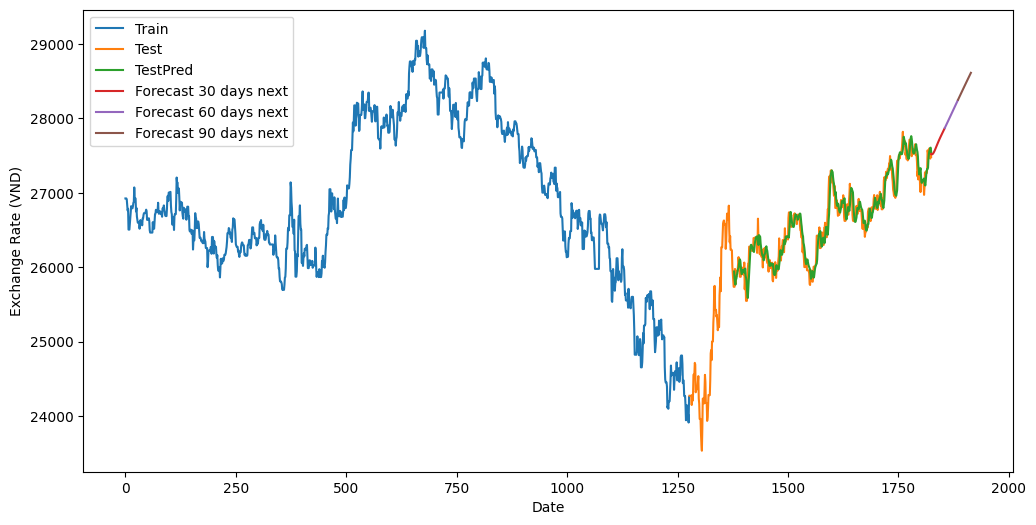

- Test: 
RMSE = 138.6127336592616
MAPE = 0.4054956203967499
MAE = 108.00939422539166


In [47]:
train_eur_1_sc = eur_sc[:int(0.7 * len(eur))]
test_eur_1_sc = eur_sc[int(0.7 * len(eur)):]
# Thực hiện hàm đã cập nhật
implement_LSTM(train_eur_1_sc, test_eur_1_sc)

EUR 8:2

Epoch 1/100


c:\Users\Windows\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.2043 - val_loss: 0.0012
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0059 - val_loss: 0.0016
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0034 - val_loss: 0.0011
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0

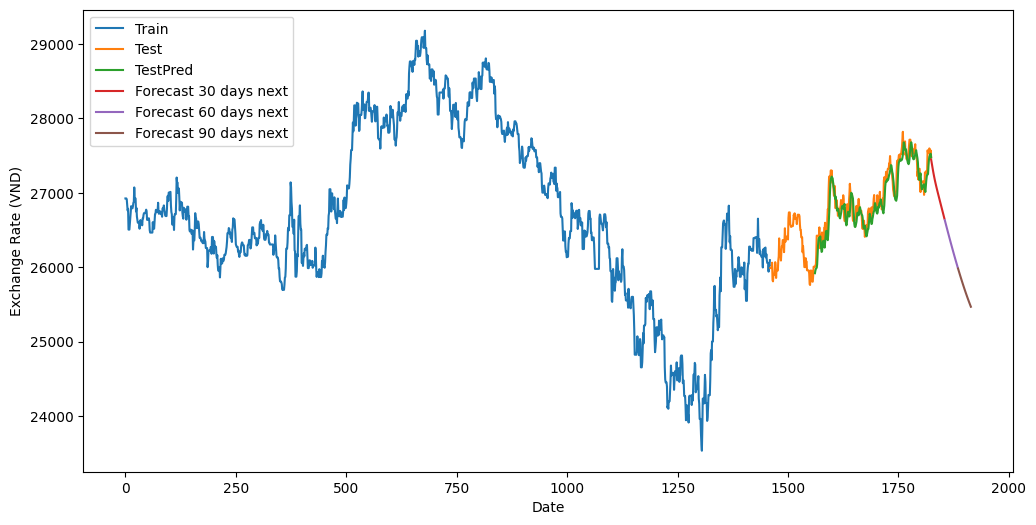

- Test: 
RMSE = 155.867503305346
MAPE = 0.44654854470239336
MAE = 120.60061553030323


In [48]:
train_eur_1_sc = eur_sc[:int(0.8 * len(eur))]
test_eur_1_sc = eur_sc[int(0.8 * len(eur)):]
# Thực hiện hàm đã cập nhật
implement_LSTM(train_eur_1_sc, test_eur_1_sc)

EUR 9:1

Epoch 1/100


c:\Users\Windows\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.2661 - val_loss: 0.0029
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0072 - val_loss: 0.0013
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0043 - val_loss: 0.0012
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0

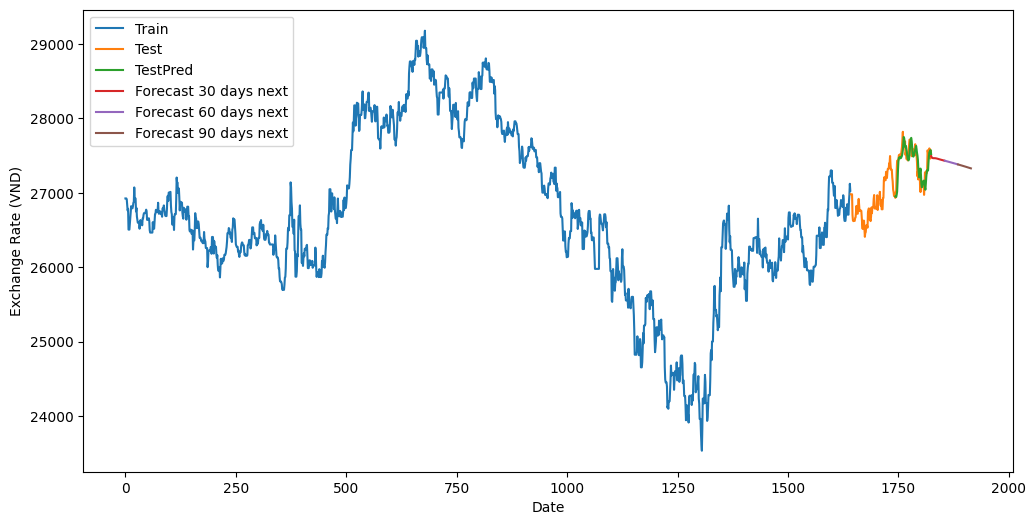

- Test: 
RMSE = 136.23687769228223
MAPE = 0.3869921572957735
MAE = 106.11359089176887


In [49]:
train_eur_1_sc = eur_sc[:int(0.9 * len(eur))]
test_eur_1_sc = eur_sc[int(0.9 * len(eur)):]
# Thực hiện hàm đã cập nhật
implement_LSTM(train_eur_1_sc, test_eur_1_sc)

# GBP_VND

In [50]:
gbp = pd.read_csv('GBP_VND.csv')

# Convert
gbp = gbp['Sale'].replace({',':''}, regex=True).astype(float)
# Scale data
# Scaler model
scaler = MinMaxScaler(feature_range=(0, 1))
# EUR - VND
gbp_sc = scaler.fit_transform(np.array(gbp).reshape(-1, 1))

GBP 7:3

Epoch 1/100


c:\Users\Windows\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.2883 - val_loss: 0.0202
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0110 - val_loss: 0.0023
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0036 - val_loss: 0.0016
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0029 - val_loss: 0.0015
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0018 - val_loss: 9.9030e-04
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss:

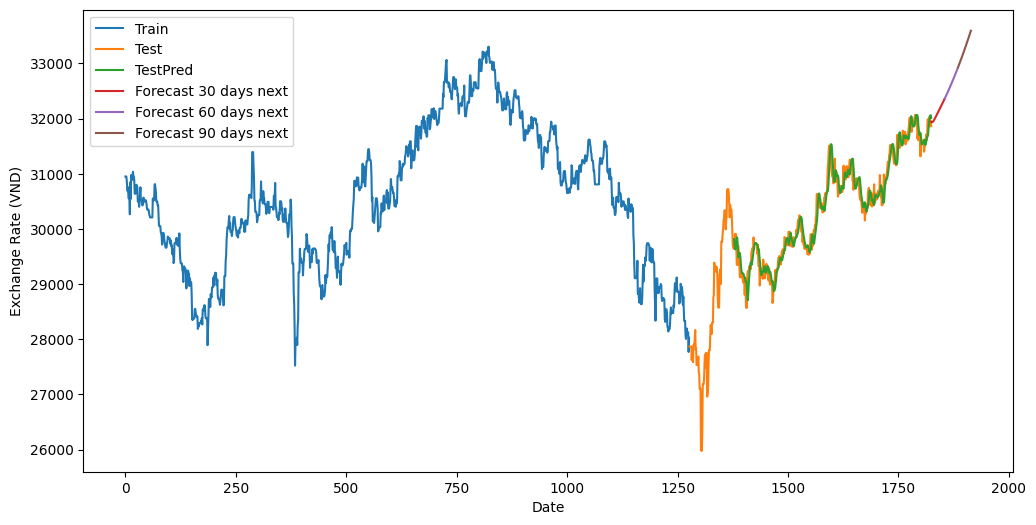

- Test: 
RMSE = 187.1210245129713
MAPE = 0.4775453373992291
MAE = 145.0694429879754


In [51]:
train_gbp_1_sc = gbp_sc[:int(0.7 * len(eur))]
test_gbp_1_sc = gbp_sc[int(0.7 * len(eur)):]
# Thực hiện hàm đã cập nhật
implement_LSTM(train_gbp_1_sc, test_gbp_1_sc)

GBP 8:2

c:\Users\Windows\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0788 - val_loss: 0.0090
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0057 - val_loss: 0.0010
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0025 - val_loss: 9.2829e-04
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0019 - val_loss: 9.3517e-04
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0018 - val_loss: 8.7029e-04
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0017 - val_loss: 8.3818e-04
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0019 - val_loss: 8.2660e-04
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0016 - val_loss: 8.8592e-04
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0017 - val_loss: 9.9915e-04
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0017 - val_loss: 8.3661e-04
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0018 - val_loss: 9.0243e-04
Epoch 12/100
22/

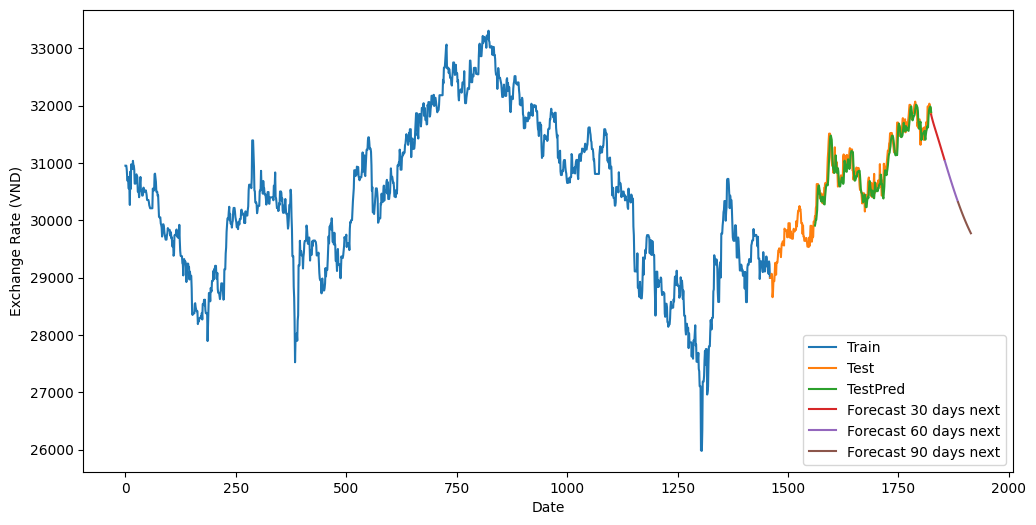

- Test: 
RMSE = 183.63684908932248
MAPE = 0.45194707642564147
MAE = 140.52529444838999


In [52]:
train_gbp_1_sc = gbp_sc[:int(0.8 * len(eur))]
test_gbp_1_sc = gbp_sc[int(0.8 * len(eur)):]
# Thực hiện hàm đã cập nhật
implement_LSTM(train_gbp_1_sc, test_gbp_1_sc)

GBP 9:1

Epoch 1/100


c:\Users\Windows\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.1712 - val_loss: 0.0207
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0081 - val_loss: 0.0018
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0032 - val_loss: 0.0010
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0030 - val_loss: 0.0013
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0021 - val_loss: 0.0010
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0021 - val_loss: 7.6117e-04
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0022 - val_loss: 7.3463e-04
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0019 - val_loss: 7.3166e-04
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0018 - val_loss: 6.6865e-04
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0018 - val_loss: 8.0498e-04
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0017 - val_loss: 6.8807e-04
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 

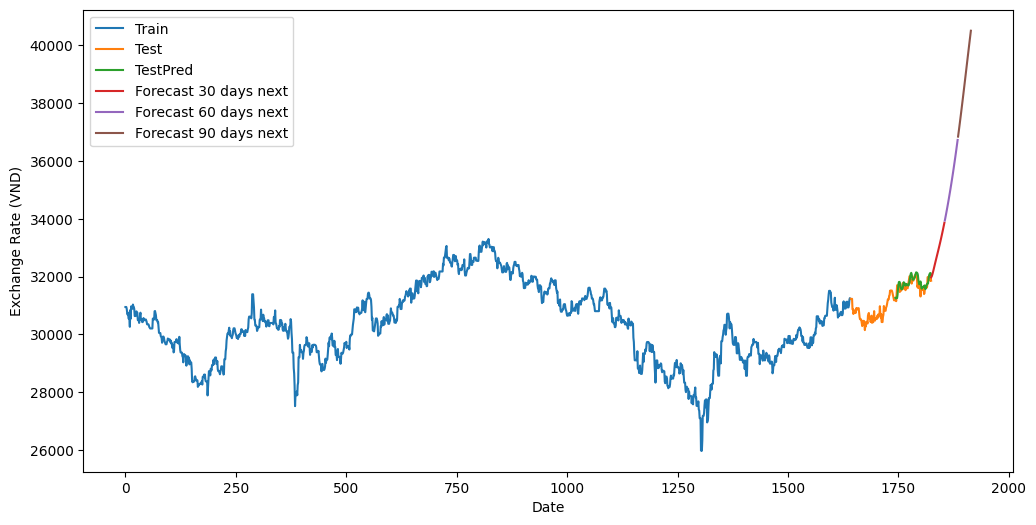

- Test: 
RMSE = 179.47043505366312
MAPE = 0.43953671686510176
MAE = 139.23318407012212


In [53]:
train_gbp_1_sc = gbp_sc[:int(0.9 * len(eur))]
test_gbp_1_sc = gbp_sc[int(0.9 * len(eur)):]
# Thực hiện hàm đã cập nhật
implement_LSTM(train_gbp_1_sc, test_gbp_1_sc)

# JPY_VND

In [54]:
jpy = pd.read_csv('JPY_VND.csv')

# Convert
jpy = jpy['Sale'].replace({',':''}, regex=True).astype(float)
# Scale data
# Scaler model
scaler = MinMaxScaler(feature_range=(0, 1))
# EUR - VND
jpy_sc = scaler.fit_transform(np.array(jpy).reshape(-1, 1))

JPY 7:3

c:\Users\Windows\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - loss: 0.3533 - val_loss: 0.0239
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0084 - val_loss: 0.0145
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0038 - val_loss: 0.0117
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0030 - val_loss: 0.0104
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0023 - val_loss: 0.0074
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0019 - val_loss: 0.0053
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0015 - val_loss: 0.0037
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0013 - val_loss: 0.0027
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0010 - val_loss: 0.0016
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 9.0826e-04 - val_loss: 0.0013
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/

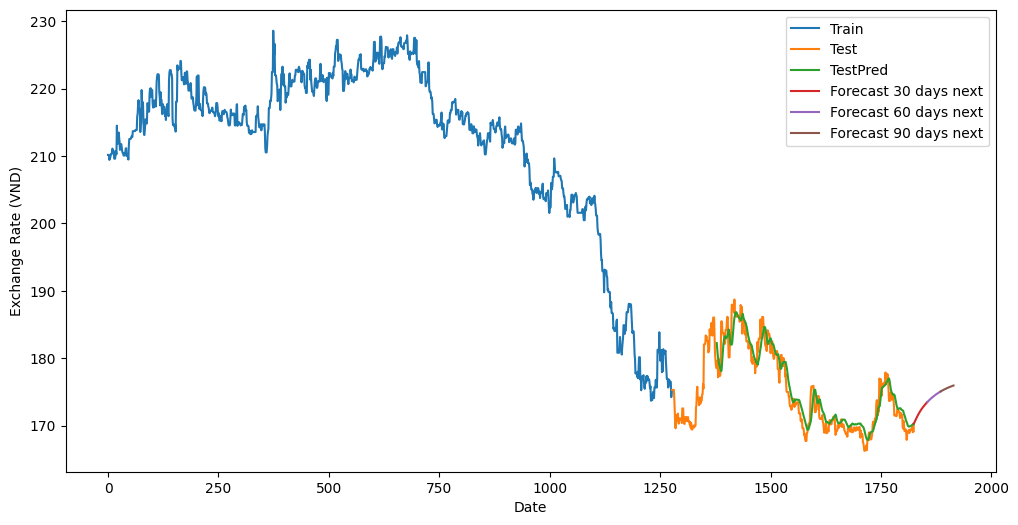

- Test: 
RMSE = 1.7951379663974518
MAPE = 0.7909268812321861
MAE = 1.3895298668095462


In [58]:
train_jpy_1_sc = jpy_sc[:int(0.7 * len(eur))]
test_jpy_1_sc = jpy_sc[int(0.7 * len(eur)):]
# Thực hiện hàm đã cập nhật
implement_LSTM(train_jpy_1_sc, test_jpy_1_sc)

JPY 8:2

c:\Users\Windows\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - loss: 0.2762 - val_loss: 0.0130
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0074 - val_loss: 0.0155
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0039 - val_loss: 0.0088
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0023 - val_loss: 0.0052
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0017 - val_loss: 0.0032
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step

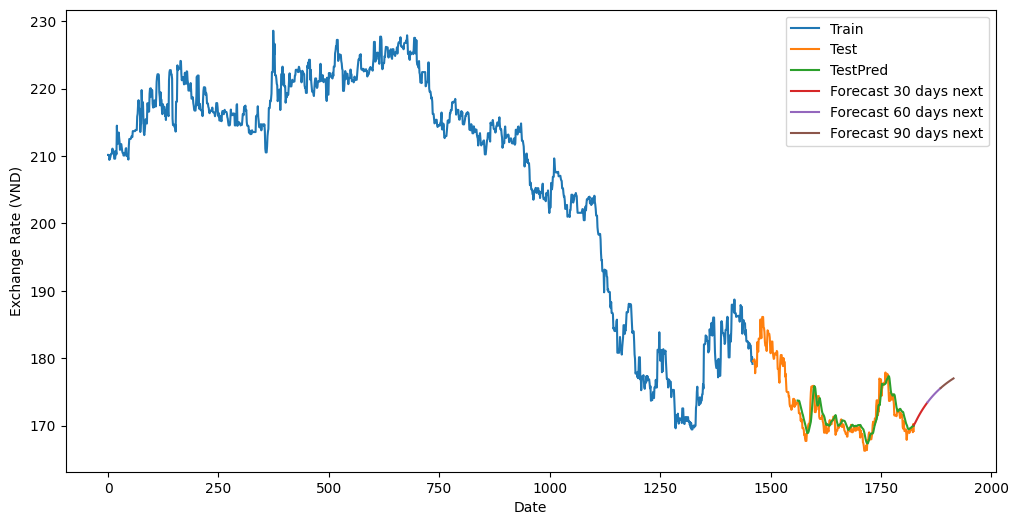

- Test: 
RMSE = 1.4681440604670088
MAPE = 0.6578354476510225
MAE = 1.1257520617860735


In [56]:
train_jpy_1_sc = jpy_sc[:int(0.8 * len(eur))]
test_jpy_1_sc = jpy_sc[int(0.8 * len(eur)):]
# Thực hiện hàm đã cập nhật
implement_LSTM(train_jpy_1_sc, test_jpy_1_sc)

JPY 9:1

Epoch 1/100


c:\Users\Windows\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.1549 - val_loss: 0.0051
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0076 - val_loss: 0.0050
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0012 - val_loss: 8.5795e-04
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0011 - val_loss: 7.3672e-04
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0010 - val_loss: 7.1571e-04
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 9.5241e-04 - val_loss: 6.9357e-04
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0011 - val_loss: 6.7928e-04
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 9.6534e-04 - val_loss: 6.8460e-04
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 9.8375e-04 - val_loss: 6.8960e-04
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 9.4959e-04 - val_loss: 7.0069e-04
Epoch 12/100
25/

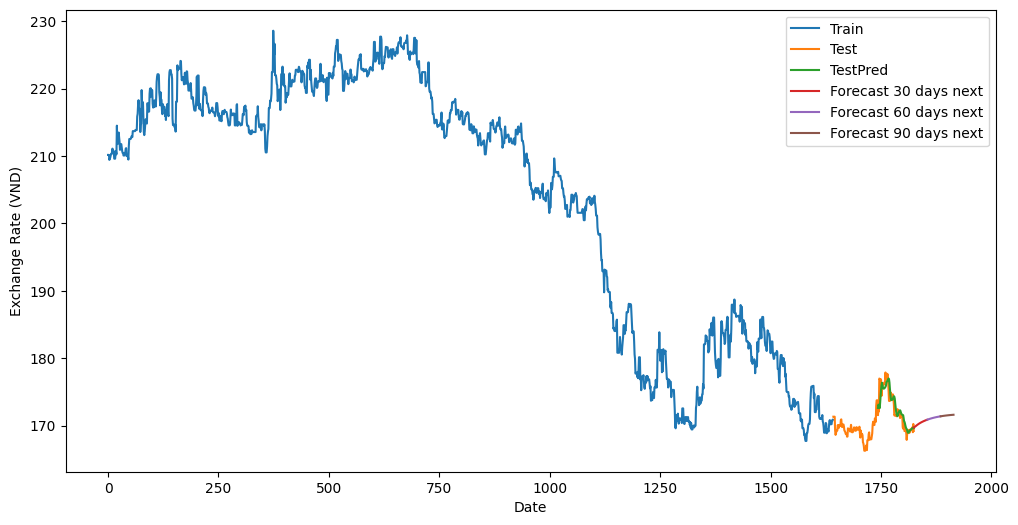

- Test: 
RMSE = 1.310393804902471
MAPE = 0.536352121588922
MAE = 0.9307593294469337


In [59]:
train_jpy_1_sc = jpy_sc[:int(0.9 * len(eur))]
test_jpy_1_sc = jpy_sc[int(0.9 * len(eur)):]
# Thực hiện hàm đã cập nhật
implement_LSTM(train_jpy_1_sc, test_jpy_1_sc)